In [ ]:
# GOAL 1: STUDENT PERFORMANCE CLASSIFICATION
# Using Support Vector Machine (SVM) and K-Nearest Neighbours (KNN)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import joblib
import numpy as np


In [ ]:
# ================= LOAD DATASET =================
df = pd.read_csv("student_scores_selected_features.csv")

# Define performance categories
# Use three categories: Low, Average, Excellent
if 'performance_category' not in df.columns:
    df['performance_category'] = pd.cut(
        df['average_score'],
        bins=[0, 60, 75, 100],
        labels=['Low', 'Average', 'Excellent'],  # Only 3 classes
        include_lowest=True
    )

# Encode target for SVM
le = LabelEncoder()
df['performance_encoded'] = le.fit_transform(df['performance_category'])

# Remove Leakage Columns
leakage_cols = [col for col in df.columns if 'score' in col.lower() and col != 'average_score']
df = df.drop(columns=leakage_cols, errors='ignore')

# Select numeric features
X = df.select_dtypes(include=['number']).drop(columns=['performance_encoded'], errors='ignore')
y = df['performance_encoded']

# Data Splitting
# Option: keep all 'Low' examples in training
low_idx = df[df['performance_category'] == 'Low'].index
other_idx = df[df['performance_category'] != 'Low'].index

# Convert other_idx to Series to allow sampling
other_idx_series = pd.Series(other_idx)

# Test set: 20% of non-Low samples
test_idx = other_idx_series.sample(frac=0.2, random_state=42).to_list()
train_idx = list(set(df.index) - set(test_idx))

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# SMOTE
from imblearn.over_sampling import SMOTE

min_class = y_train.value_counts().min()
smote = SMOTE(random_state=42, k_neighbors=max(1, min_class - 1))
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original training class distribution:\n", y_train.value_counts())
print("After SMOTE class distribution:\n", pd.Series(y_train_res).value_counts())

# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


Original training class distribution:
 performance_encoded
2    1244
0     233
1     121
3       2
Name: count, dtype: int64
After SMOTE class distribution:
 performance_encoded
2    1244
1    1244
0    1244
3    1244
Name: count, dtype: int64



=== Support Vector Machine (SVM) ===
SVM Accuracy: 0.9425

Classification Report (SVM):
              precision    recall  f1-score   support

     Average       0.87      0.98      0.92        62
   Excellent       0.72      0.97      0.83        32
        High       1.00      0.93      0.96       306

   micro avg       0.94      0.94      0.94       400
   macro avg       0.86      0.96      0.90       400
weighted avg       0.96      0.94      0.95       400



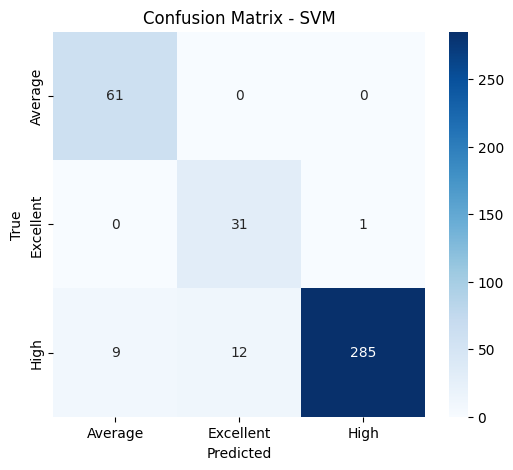

In [ ]:
# ================= SVM MODEL =================
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("\n=== Support Vector Machine (SVM) ===")
svm = SVC(kernel='rbf', gamma='auto', class_weight='balanced', probability=True)
svm.fit(X_train_scaled, y_train_res)

# ================= PREDICTIONS =================
y_pred_svm = svm.predict(X_test_scaled)

# Accuracy
svm_acc = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", svm_acc)

# Classification Report
print("\nClassification Report (SVM):")
print(classification_report(
    y_test,
    y_pred_svm,
    labels=np.unique(y_test),
    target_names=[le.classes_[i] for i in np.unique(y_test)]
))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_test, y_pred_svm, labels=np.unique(y_test)),
    annot=True, fmt="d", cmap="Blues",
    xticklabels=[le.classes_[i] for i in np.unique(y_test)],
    yticklabels=[le.classes_[i] for i in np.unique(y_test)]
)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import joblib

# Save model, scaler, and feature names
joblib.dump(svm, "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns.tolist(), "svm_features.pkl")



['svm_features.pkl']

In [ ]:
print(X.columns)

Index(['absence_days', 'weekly_self_study_hours',
       'career_aspiration_Business Owner', 'career_aspiration_Doctor',
       'science_avg', 'humanities_avg', 'performance_consistency',
       'average_score'],
      dtype='object')



=== K-Nearest Neighbors (KNN) ===
KNN Accuracy: 0.89

Classification Report (KNN):
              precision    recall  f1-score   support

     Average       0.70      0.90      0.79        62
   Excellent       0.74      0.88      0.80        32
        High       0.97      0.89      0.93       306

   micro avg       0.89      0.89      0.89       400
   macro avg       0.80      0.89      0.84       400
weighted avg       0.91      0.89      0.90       400



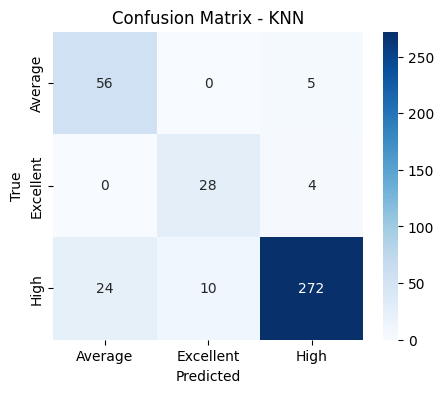

In [ ]:
# ============= K-Nearest Neighbors (KNN) =============
print("\n=== K-Nearest Neighbors (KNN) ===")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Initialize KNN (you can adjust n_neighbors)
knn = KNeighborsClassifier(n_neighbors=5)

# Train on resampled & scaled data
knn.fit(X_train_scaled, y_train_res)

# Predict on the test set
y_pred_knn = knn.predict(X_test_scaled)

# Accuracy
knn_acc = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", knn_acc)

# Handle possible class mismatch
existing_labels = np.unique(y_test)  # only classes present in test set
existing_class_names = le.classes_[existing_labels]

# Classification Report
print("\nClassification Report (KNN):")
print(classification_report(
    y_test, y_pred_knn, 
    labels=existing_labels, 
    target_names=existing_class_names
))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_knn, labels=existing_labels), 
    annot=True, fmt="d", cmap="Blues",
    xticklabels=existing_class_names, 
    yticklabels=existing_class_names
)
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


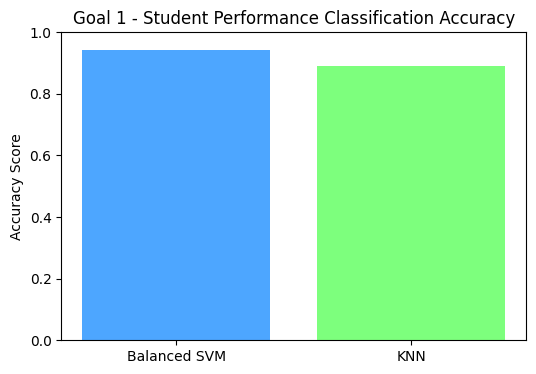

In [ ]:
# ================== COMPARE MODEL ACCURACIES ==================

acc_scores = {
    "Balanced SVM": svm_acc,
    "KNN": knn_acc
}

plt.figure(figsize=(6,4))
plt.bar(acc_scores.keys(), acc_scores.values(), color=['#4da6ff', '#7dff7d'])
plt.title("Goal 1 - Student Performance Classification Accuracy")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)  # keeps chart scale consistent
plt.show()


In [ ]:
import sys
print(sys.executable)


c:\Users\User\Student_Performance_Analysis_5011CEM\venv\Scripts\python.exe


In [ ]:
#GOAL 2: PROPHET - PERFORMANCE TREND ANALYSIS

from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd


=== 📊 Prophet Forecast for All Students ===


14:11:14 - cmdstanpy - INFO - Chain [1] start processing
14:11:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\User\Student_Performance_Analysis_5011CEM\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


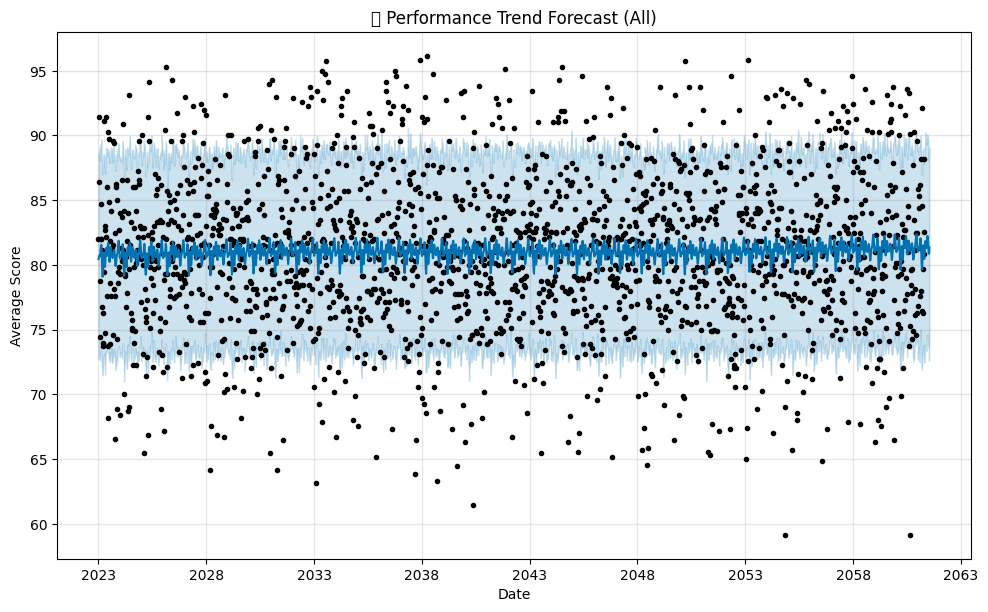

In [ ]:
# Ensure there’s a date column for time-series (if not, simulate weekly data)
if 'date' not in df.columns:
    df['date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='W')

# Group average scores by demographic and time (example: by gender)
if 'gender' in df.columns:
    groups = df['gender'].unique()
else:
    groups = ['All']
    df['gender'] = 'All'

# Plot trends for each demographic group
for g in groups:
    print(f"\n=== 📊 Prophet Forecast for {g} Students ===")
    
    group_df = df[df['gender'] == g].copy()
    
    # Create Prophet-compatible dataframe
    prophet_df = group_df[['date', 'average_score']].rename(columns={'date': 'ds', 'average_score': 'y'})
    
    # Fit Prophet model
    m = Prophet()
    m.fit(prophet_df)
    
    # Forecast future performance (next 12 weeks)
    future = m.make_future_dataframe(periods=12, freq='W')
    forecast = m.predict(future)
    
    # Plot forecast
    fig1 = m.plot(forecast)
    plt.title(f"📈 Performance Trend Forecast ({g})")
    plt.xlabel("Date")
    plt.ylabel("Average Score")
    plt.show()


=== ⚡ XGBoost – Predict At-Risk Students (Behavior-Based) ===
Accuracy: 0.6300

Classification Report:

              precision    recall  f1-score   support

 Not At Risk       0.64      0.65      0.65       209
     At Risk       0.61      0.61      0.61       191

    accuracy                           0.63       400
   macro avg       0.63      0.63      0.63       400
weighted avg       0.63      0.63      0.63       400



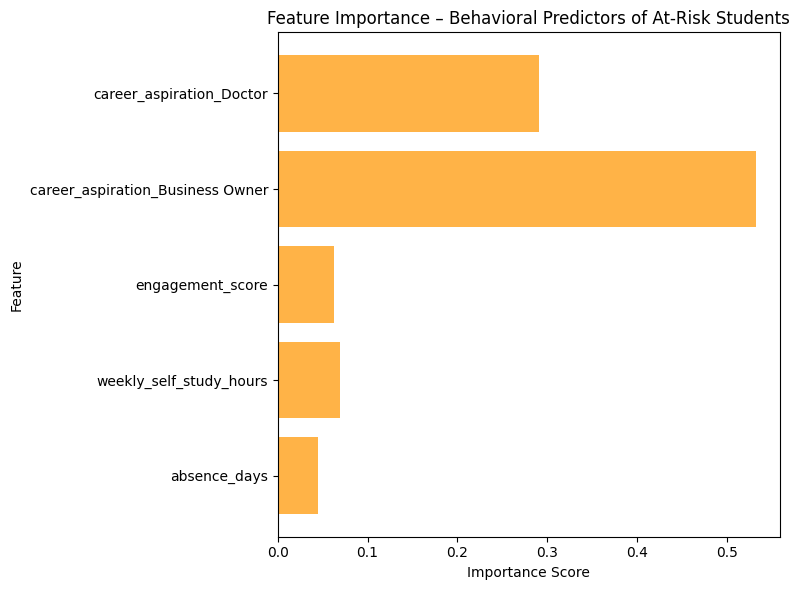

In [ ]:
#XGBoost – Predict At-Risk Students 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("student_scores_selected_features.csv")

#Define target based on performance (e.g., average_score < threshold)
#    The model will use behavioral features to predict this.
threshold = df['average_score'].median()
df['risk_label'] = (df['average_score'] < threshold).astype(int)  # 1 = At Risk

#Select only behavioral predictors
behavioral_features = [
    'absence_days',
    'weekly_self_study_hours',
    'engagement_score'
]
optional_cols = [c for c in df.columns if "career_aspiration" in c]
behavioral_features.extend(optional_cols)

X = df[behavioral_features].copy()
y = df['risk_label']

# Encode any categorical columns
X = pd.get_dummies(X, drop_first=True)

#Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train XGBoost
print("\n=== ⚡ XGBoost – Predict At-Risk Students (Behavior-Based) ===")
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=3,
)
xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)

#Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Not At Risk", "At Risk"]))

#Feature Importance
importances = xgb.feature_importances_
features = X.columns

plt.figure(figsize=(8,6))
plt.barh(features, importances, color="#FFB347")
plt.title("Feature Importance – Behavioral Predictors of At-Risk Students")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Target distribution: risk_label
0    1612
1     388
Name: count, dtype: int64
Using TRUE behavioral features: ['humanities_avg', 'performance_consistency', 'science_avg', 'engagement_score', 'weekly_self_study_hours']

Accuracy: 0.9850

Classification Report:
              precision    recall  f1-score   support

 Not At Risk       0.99      0.99      0.99       322
     At Risk       0.95      0.97      0.96        78

    accuracy                           0.98       400
   macro avg       0.97      0.98      0.98       400
weighted avg       0.99      0.98      0.99       400

Confusion Matrix:
 [[318   4]
 [  2  76]]


c:\Users\User\Student_Performance_Analysis_5011CEM\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:11:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


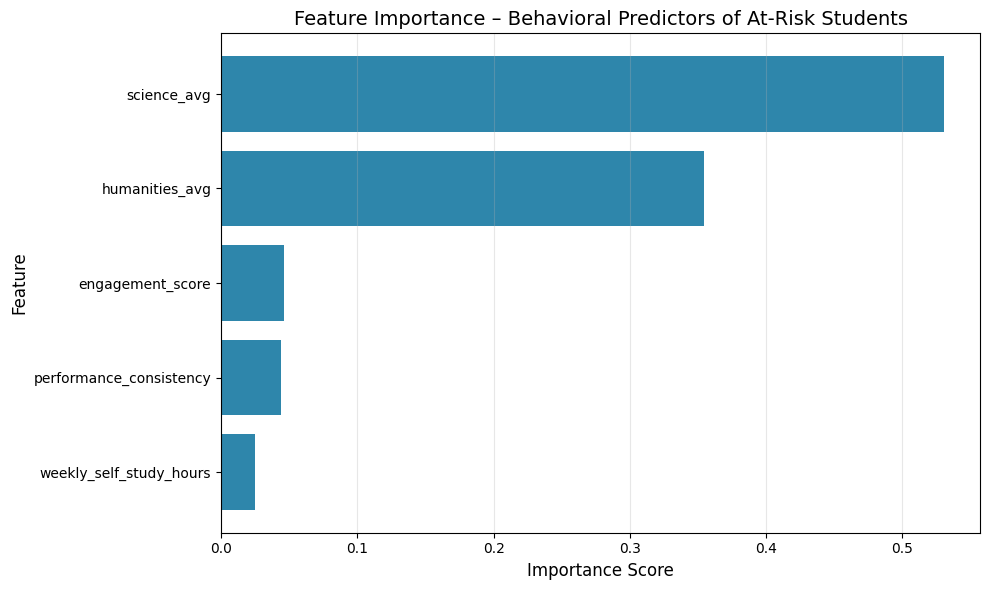


Top 5 Most Important Features:
                   feature  importance
4  weekly_self_study_hours    0.024908
1  performance_consistency    0.043651
3         engagement_score    0.046526
0           humanities_avg    0.354562
2              science_avg    0.530352


In [ ]:
# ================= IMPROVED XGBoost – Predict At-Risk Students (Balanced & Probabilistic) =================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import numpy as np

# ---------------- Load dataset ----------------
df = pd.read_csv("student_scores_selected_features.csv")

# ---------------- Define risk target ----------------
# Bottom 20% or below 60 considered At Risk
threshold = max(60, df['average_score'].quantile(0.2))
df['risk_label'] = (df['average_score'] < threshold).astype(int)
print(f"Target distribution: {df['risk_label'].value_counts()}")

# ---------------- Select behavioral features ----------------
features = [
    'science_avg',
    'humanities_avg',
    'engagement_score',
    'performance_consistency',
    'weekly_self_study_hours'
]

# Include other behavioral/activity features (attendance, participation, online activity)
behavioral_features = [c for c in df.columns if any(
    keyword in c.lower() for keyword in ['participation', 'online', 'activity', 'behavior', 'attendance']
)]
features.extend(behavioral_features)

# Remove duplicates and ensure columns exist
features = list(set(features))
features = [f for f in features if f in df.columns]

print(f"Using TRUE behavioral features: {features}")

# ---------------- Prepare data ----------------
X = df[features].copy()
y = df['risk_label']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Fill missing values
X = X.fillna(X.mean())

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------- Train XGBoost ----------------
# Reduced pos_weight to prevent over-sensitivity
pos_weight = 2

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    eval_metric='logloss',
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=pos_weight,   # balance At-Risk class
    use_label_encoder=False
)

xgb.fit(X_train_scaled, y_train)

# ---------------- Predictions & Probabilities ----------------
y_pred = xgb.predict(X_test_scaled)
y_pred_proba = xgb.predict_proba(X_test_scaled)[:, 1]  # probability of At Risk

# ---------------- Evaluation ----------------
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not At Risk", "At Risk"]))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ---------------- Feature Importance ----------------
importances = xgb.feature_importances_
features_list = X.columns

feature_importance_df = pd.DataFrame({
    'feature': features_list,
    'importance': importances
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color="#2E86AB")
plt.title("Feature Importance – Behavioral Predictors of At-Risk Students", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Top 5 features
print("\nTop 5 Most Important Features:")
print(feature_importance_df.tail(5))



In [ ]:
import joblib

# Save the trained XGBoost model
joblib.dump(xgb, "xgb_model.pkl")

# Save the scaler used for feature scaling
joblib.dump(scaler, "xgb_scaler.pkl")

# Save the feature names
joblib.dump(X.columns.tolist(), "xgb_features.pkl")

print("XGBoost model, scaler, and features saved!")

XGBoost model, scaler, and features saved!


In [ ]:
df['average_score'].describe()


count    2000.000000
mean       80.980357
std         6.042224
min        59.142857
25%        77.285714
50%        81.000000
75%        84.714286
max        96.142857
Name: average_score, dtype: float64